In [1]:
from randomDistricts import Hierarchy_2D
from gerrychain import (Graph, Partition, MarkovChain,
                        proposals, updaters, constraints, accept, Election)
from shapely.geometry import Polygon
from gerrychain.updaters import Tally, cut_edges
from gerrychain.proposals import recom
from treelib import Node, Tree
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns
import pandas as pd
from functools import partial

## Build Grid in geopandas

In [53]:
dim = 16
xmin,ymin,xmax,ymax = 0,0,dim,dim

length = 1
wide = 1

cols = list(range(int(np.floor(xmin)), int(np.ceil(xmax))))
rows = list(range(int(np.floor(ymin)), int(np.ceil(ymax))))
# rows.reverse()

polygons = []
cords = []
for x in cols:
    for y in rows:
        polygons.append( Polygon([(x,y), (x+wide, y), (x+wide, y+length), (x, y+length)]) )
        cords.append((x,y))

grid = gpd.GeoDataFrame({'geometry':polygons, "col": list(zip(*cords))[0], "row": list(zip(*cords))[1]})

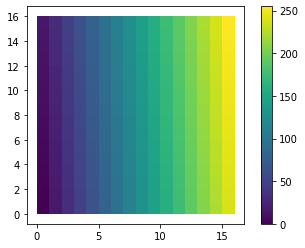

In [54]:
grid.reset_index().plot(column="index", legend=True)
plt.show()

In [47]:
geoids_rc = np.zeros(len(grid), dtype="object")
for x in grid.iterrows():
    geoids_rc[x[0]] =  "1" + str(x[1].row + 1) + str(x[1].col + 1)

In [137]:
geoids_sq = np.zeros(len(grid), dtype="object")
for x in grid.iterrows():
    geoid = "1"
    row = x[1].row
    col = x[1].col
    threshold = dim / 2
    if row < threshold:
        geoid = geoid + "1" if col < threshold else geoid + "2"  
    else:
        geoid = geoid + "3" if col < threshold else geoid + "4"
    if dim == 16:
        if row % threshold < 4:
            geoid = geoid + "1" if col % threshold < 4 else geoid + "2"  
        else:
            geoid = geoid + "3" if col % threshold < 4 else geoid + "4"
        if row % (threshold/2) < 2:
            geoid = geoid + "1" if col % (threshold/2) < 2 else geoid + "2"  
        else:
            geoid = geoid + "3" if col % (threshold/2) < 2 else geoid + "4"
    if dim == 8:
        if row % threshold < 2:
            geoid = geoid + "1" if col % threshold < 2 else geoid + "2"  
        else:
            geoid = geoid + "3" if col % threshold < 2 else geoid + "4"
    if row % 2 == 0:
            geoid = geoid + "1" if col % 2 == 0 else geoid + "2"  
    else:
        geoid = geoid + "3" if col % 2 == 0 else geoid + "4"
    
    geoids_sq[x[0]] = geoid
#     print(geoid)

In [139]:
grid["geoid_sq"] = geoids_sq
# grid["geoid_rc"] = geoids_rc
grid["POP"] = 100

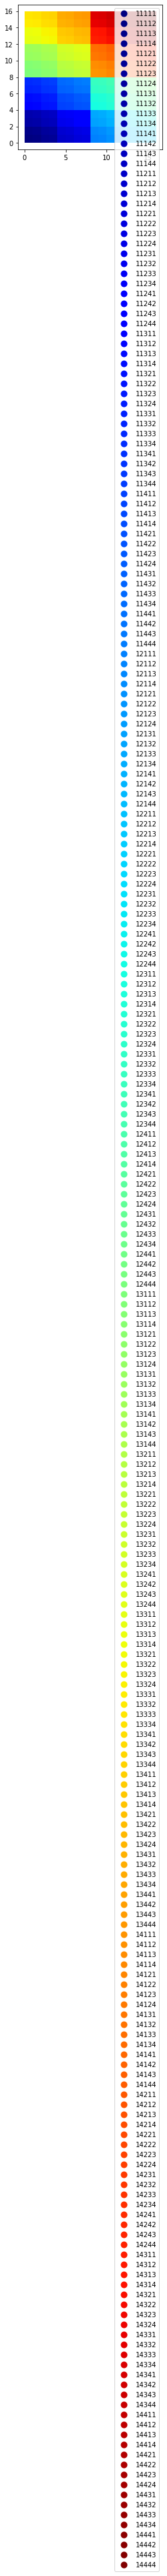

In [140]:
grid.reset_index().plot(column="geoid_sq", cmap="jet", legend=True)

In [141]:
len(grid.geoid_sq.unique())

256

In [98]:
2**7

128

In [99]:
16*16

256

In [80]:
8*8

64

In [142]:
grid.to_file("grids/{}_{}_grid_test.shp".format(dim,dim))

# Districts on Grids

In [9]:
def all_districts(sizes, nodes, h, geoid):
    districts = {size:{} for size in sizes}
    for size in sizes:
        ds = set()
        for i in range(len(nodes[size])):
            p = Partition(h.graph, {n: nodes[size][i][n] for n in h.graph.nodes},
                      updaters={"cut_edges": cut_edges, "population": Tally("POP")})
            ds |= set(p.parts.values())

        d_parts = []
        d_dicts = []
        for d in ds:
            d_parts.append(Partition(h.graph, {n: int(n in d) for n in h.graph.nodes},
                           updaters={"cut_edges": cut_edges, "population": Tally("POP")}))
            d_dicts.append({h.graph.nodes[n][geoid]: int(n in d) for n in h.graph.nodes})
        districts[size]["dicts"] = d_dicts
        districts[size]["parts"] = d_parts
    return districts

In [10]:
def variance_size_ratio(districts, h):
    variances = []
    sizes = []
    ratios = []
    for k,v in districts.items():
        vs = [h.assign_district_tree_varriance(d) for d in v["dicts"]]
        variances.extend(vs)
        ratios.extend(vs / min(vs))
        sizes.extend([k for d in v["dicts"]])
    return variances, sizes, ratios

## How does this look across the viable districts on a 4x4 grid?

In [2]:
nodes_4_4 = {2:{}, 4: {}, 8:{}}

for size in [2,4,8]:
    with open("../../metagraph/Week_6/metagraph-visualizations/enums/enum_[4,4]_[{}]_{}_rc.txt".format(size,
                                                                                                       int(16/size))) as file:
        for i, line in enumerate(file):
            nodes_4_4[size][i] = np.fromstring(line, dtype=int, sep=',')

In [335]:
for size in [2,4,8]:
    print("{} districts of size {}".format(len(districts[size]["parts"]), size))

24 districts of size 2
89 districts of size 4
140 districts of size 8


In [3]:
h_sq = Hierarchy_2D("grids/4_4_grid_test.shp", "geoid_sq", "POP" , 
                   ["POP"], [1,1,1])
h_rc = Hierarchy_2D("grids/4_4_grid_test.shp", "geoid_rc", "POP" , 
                   ["POP"], [1,1,1])

In [14]:
dists_sq = all_districts([2,4,8], nodes_4_4, h_sq, "geoid_sq")

In [15]:
dists_rc = all_districts([2,4,8], nodes_4_4, h_rc, "geoid_rc")

In [30]:
vars_sq, sizes_sq, ratios_sq = variance_size_ratio(dists_sq, h_sq)

In [31]:
vars_rc, sizes_rc, ratios_rc = variance_size_ratio(dists_rc, h_rc)

In [152]:
data44grid = pd.DataFrame()
for size in [2,4,8]:
    for treetype, vs, sizes in [("sq", vars_sq, sizes_sq),("rc", vars_rc, sizes_rc)]:
        df = pd.DataFrame(pd.Series(list(zip(*filter(lambda x: x[1] == size, 
                                                     list(zip(vs, sizes)))))[0]).value_counts(), 
                 columns=["counts"]).assign(size=str(size), 
                                            tree_type=treetype).reset_index().rename(columns={"index": "var"})
        df["ratio"] = df["var"] / min(df["var"])
        data44grid = data44grid.append(df)
   

In [61]:
def draw_results_grid(data, sizes, vs, ratios, title, treetype="sq", figsize=(12,12)):
    fig, axs = plt.subplots(3,2, figsize=figsize)

    fig.suptitle(title)

    sns.scatterplot(data=data.query("tree_type == @treetype"), x="size", y="ratio", 
                    hue="counts", size="counts", palette="cool", ax=axs[0,0])
    axs[0,0].set_xlabel("District Size")
    axs[0,0].set_ylabel('Variance Ratio: Random/Min')

    sns.scatterplot(data=data.query("tree_type == @treetype"), x="size", y="var", 
                    hue="counts", size="counts", palette="cool", ax=axs[0,1])
    # axs[0,1].scatter(sizes_rc, vars_rc, alpha=0.1)
    axs[0,1].set_xlabel("District Size")
    axs[0,1].set_ylabel('District Variance')

    sns.boxplot(x=sizes, y=ratios, ax=axs[1,0], palette="cool", whis=(1,99))
    axs[1,0].set_xlabel("District Size")
    axs[1,0].set_ylabel('Variance Ratio: Random/Min')

    sns.boxplot(x=sizes, y=vs, ax=axs[1,1], palette="cool", whis=(1,99))
    axs[1,1].set_xlabel("District Size")
    axs[1,1].set_ylabel('District Variance')

    sns.violinplot(x=sizes, y=ratios, palette="cool", ax=axs[2,0], inner="quartile", scale="width")
    axs[2,0].set_xlabel("District Size")
    axs[2,0].set_ylabel('Variance Ratio: Random/Min')

    sns.violinplot(x=sizes, y=vs, palette="cool", ax=axs[2,1],inner="quartile", scale="width")
    axs[2,1].set_xlabel("District Size")
    axs[2,1].set_ylabel('District Variance')
    
    pad = 10
    for ax, col in zip(axs[0], ["Variance Ratio: Random/Min", "Variance"]):
        ax.annotate(col, xy=(0.5, 1), xytext=(0, ax.xaxis.labelpad + pad),
                    xycoords='axes fraction', textcoords='offset points',
                    size='large', ha='center', va='baseline')
    
    return fig, axs

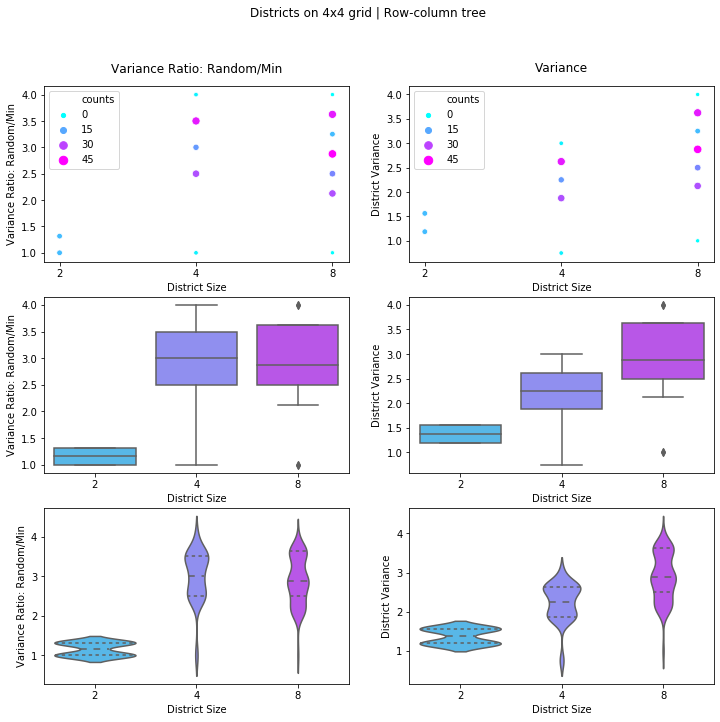

In [637]:
fig, axs = draw_results_grid(data44grid, sizes_rc, vars_rc, ratios_rc,
                  "Districts on 4x4 grid | Row-column tree", treetype="rc", figsize=(12, 11))
plt.savefig("plots/4_4_grid_row_col_tree.png", dpi=200)

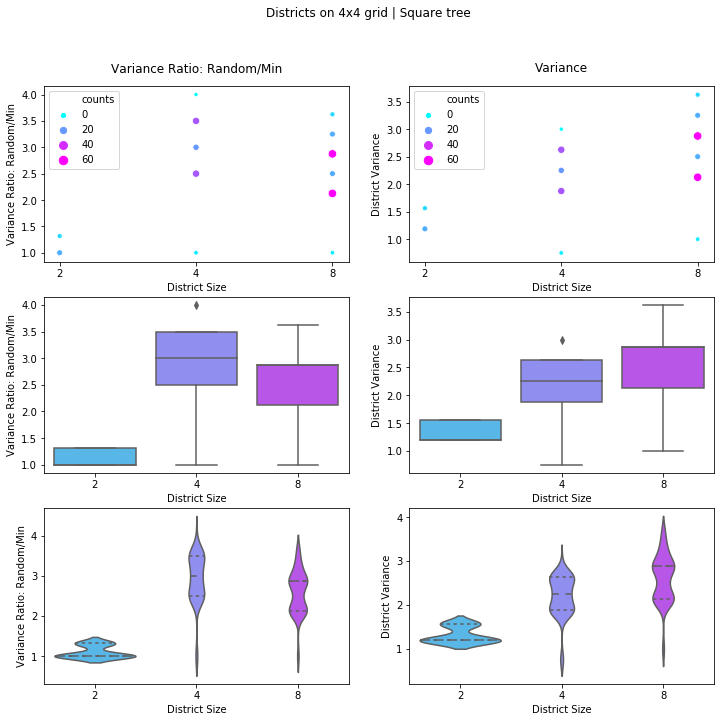

In [638]:
fig, axs = draw_results_grid(data44grid, sizes_sq, vars_sq, ratios_sq,
                  "Districts on 4x4 grid | Square tree", treetype="sq", figsize=(12, 11))
plt.savefig("plots/4_4_grid_square_tree.png", dpi=200)

## How does this look on an 8x8 grid?

In [2]:
h_8_sq = Hierarchy_2D("grids/8_8_grid_test.shp", "geoid_sq", "POP" , 
                   ["POP"], [1,1,1,1])

In [3]:
h_8_sq.tree.show()

1
├── 11
│   ├── 111
│   │   ├── 1111
│   │   ├── 1112
│   │   ├── 1113
│   │   └── 1114
│   ├── 112
│   │   ├── 1121
│   │   ├── 1122
│   │   ├── 1123
│   │   └── 1124
│   ├── 113
│   │   ├── 1131
│   │   ├── 1132
│   │   ├── 1133
│   │   └── 1134
│   └── 114
│       ├── 1141
│       ├── 1142
│       ├── 1143
│       └── 1144
├── 12
│   ├── 121
│   │   ├── 1211
│   │   ├── 1212
│   │   ├── 1213
│   │   └── 1214
│   ├── 122
│   │   ├── 1221
│   │   ├── 1222
│   │   ├── 1223
│   │   └── 1224
│   ├── 123
│   │   ├── 1231
│   │   ├── 1232
│   │   ├── 1233
│   │   └── 1234
│   └── 124
│       ├── 1241
│       ├── 1242
│       ├── 1243
│       └── 1244
├── 13
│   ├── 131
│   │   ├── 1311
│   │   ├── 1312
│   │   ├── 1313
│   │   └── 1314
│   ├── 132
│   │   ├── 1321
│   │   ├── 1322
│   │   ├── 1323
│   │   └── 1324
│   ├── 133
│   │   ├── 1331
│   │   ├── 1332
│   │   ├── 1333
│   │   └── 1334
│   └── 134
│       ├── 1341
│       ├── 1342
│       ├── 1343
│       └── 1344
└── 14
    ├── 14

In [4]:
def sample_districts(sizes, init_parts, h, geoid, pop_col="POP", tot_steps=1000):
    districts = {size:{} for size in sizes}
    
    for size, init_part in zip(sizes, init_parts):
        print(size)
        ## set up chain
        ideal_pop = size*100
        proposal = partial(recom,
                   pop_col=pop_col,
                   pop_target=ideal_pop,
                   epsilon=0.02,
                   node_repeats=1)
        pop_constraint = constraints.within_percent_of_ideal_population(init_part, 0.02)
        
        chain = MarkovChain(
            proposal=proposal,
            constraints=[pop_constraint],
            accept=accept.always_accept,
            initial_state=init_part,
            total_steps=tot_steps
        )
        
        ## run chain and gather districts
        ds = set()
        for p in chain:
            ds |= set(p.parts.values())

        ## Covert to parts
        d_parts = []
        d_dicts = []
        for d in ds:
            d_parts.append(Partition(h.graph, {n: int(n in d) for n in h.graph.nodes},
                           updaters={"cut_edges": cut_edges, "population": Tally(pop_col)}))
            d_dicts.append({h.graph.nodes[n][geoid]: int(n in d) for n in h.graph.nodes})
        
        districts[size]["dicts"] = d_dicts
        districts[size]["parts"] = d_parts
    
    return districts

In [5]:
init_part_2 = Partition(h_8_sq.graph, {n:h_8_sq.graph.nodes[n]["geoid_sq"][1:-1] 
                                       + str(int(h_8_sq.graph.nodes[n]["col"] % 2)) for n in h_8_sq.graph.nodes},
                      updaters={"cut_edges": cut_edges, "population": Tally("POP", alias="population")})

init_part_4 = Partition(h_8_sq.graph, {n:h_8_sq.graph.nodes[n]["geoid_sq"][1:-1] for n in h_8_sq.graph.nodes},
                      updaters={"cut_edges": cut_edges, "population": Tally("POP", alias="population")})
init_part_8 = Partition(h_8_sq.graph, {n: n % 8 for n in h_8_sq.graph.nodes},
                        updaters={"cut_edges": cut_edges, "population": Tally("POP", alias="population")})
init_part_16 = Partition(h_8_sq.graph, {n:h_8_sq.graph.nodes[n]["geoid_sq"][1:-2] for n in h_8_sq.graph.nodes},
         updaters={"cut_edges": cut_edges, "population": Tally("POP", alias="population")})

init_part_32 = Partition(h_8_sq.graph, {n: np.floor(h_8_sq.graph.nodes[n]["row"] / 4) for n in h_8_sq.graph.nodes},
          updaters={"cut_edges": cut_edges, "population": Tally("POP", alias="population")},)


In [6]:
sizes = [2,4,8,16,32]
init_parts = [init_part_2,init_part_4,init_part_8,init_part_16,init_part_32]

In [7]:
d = sample_districts(sizes, init_parts, h_8_sq, "geoid_sq", tot_steps=10000)

2
4
8
16
32


In [11]:
vars_8, sizes_8, ratios_8 = variance_size_ratio(d, h_8_sq)

In [12]:
data88grid = pd.DataFrame()
for size in sizes:
    df = pd.DataFrame(pd.Series(list(zip(*filter(lambda x: x[1] == size, 
                                                 list(zip(vars_8, sizes_8)))))[0]).value_counts(), 
                      columns=["counts"]).assign(size=str(size), 
                      tree_type="sq").reset_index().rename(columns={"index": "var"})
    df["ratio"] = df["var"] / min(df["var"])
    data88grid = data88grid.append(df)

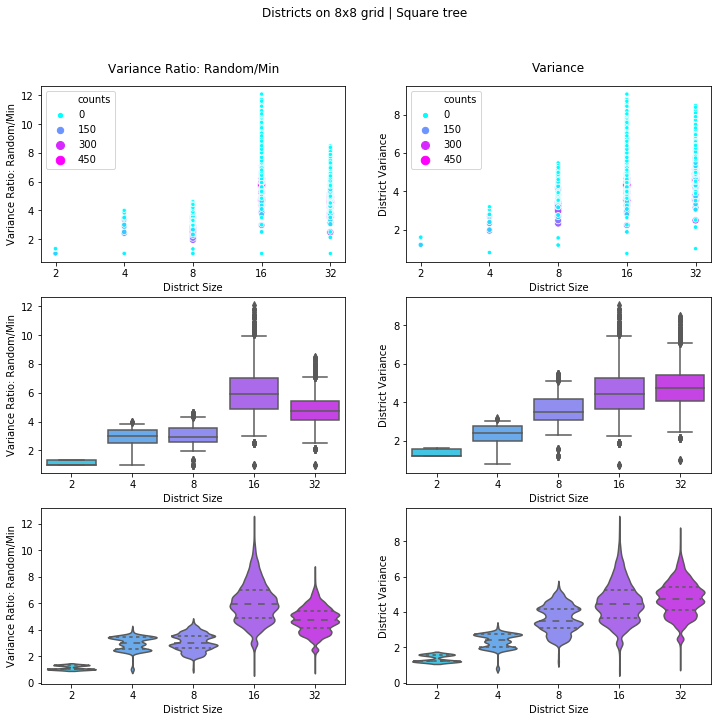

In [63]:
fig, axs = draw_results_grid(data88grid, sizes_8, vars_8, ratios_8,
                  "Districts on 8x8 grid | Square tree", treetype="sq", figsize=(12, 11))
plt.savefig("plots/8_8_grid_square_tree.png", dpi=200)

In [563]:
# 1000 long chain
# [len(d[s]["parts"]) for s in sizes]
# [278, 716, 1118, 1546]

[278, 716, 1118, 1546]

In [570]:
[len(d[s]["parts"]) for s in sizes]

[702, 4510, 8876, 10700]

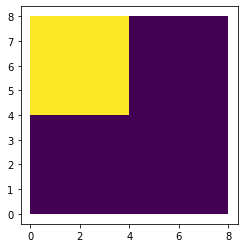

In [539]:
d[16]["parts"][5].plot()

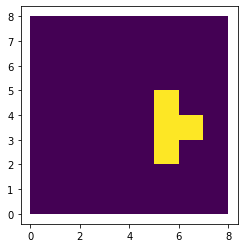

In [594]:
d[4]["parts"][80].plot()

In [540]:
h_8_sq.assign_district_tree_varriance(d[16]["dicts"][5])

0.75

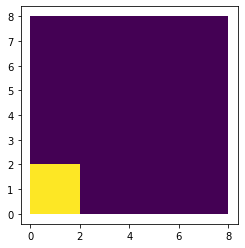

In [34]:
Partition(h_8_sq.graph, {n: int(n in [0,1,8,9]) for n in h_8_sq.graph.nodes}).plot()

## 16x16 grid

In [26]:
h_16_sq = Hierarchy_2D("grids/16_16_grid_test.shp", "geoid_sq", "POP" , 
                   ["POP"], [1,1,1,1,1])

In [113]:
init_part_2 = Partition(h_16_sq.graph, {n: h_16_sq.graph.nodes[n]["geoid_sq"][1:-1] 
                                        + str(int(h_16_sq.graph.nodes[n]["col"] % 2)) for n in h_16_sq.graph.nodes},
                      updaters={"cut_edges": cut_edges, "population": Tally("POP", alias="population")})

init_part_4 = Partition(h_16_sq.graph, {n: h_16_sq.graph.nodes[n]["geoid_sq"][1:-1] for n in h_16_sq.graph.nodes},
                      updaters={"cut_edges": cut_edges, "population": Tally("POP", alias="population")})

init_part_8 = Partition(h_16_sq.graph, {n: str(n % 16) 
                            + str(int(h_16_sq.graph.nodes[n]["col"] < 8)) for n in h_16_sq.graph.nodes},
                        updaters={"cut_edges": cut_edges, "population": Tally("POP", alias="population")})

init_part_16_row = Partition(h_16_sq.graph, {n: n % 16 for n in h_16_sq.graph.nodes},
                        updaters={"cut_edges": cut_edges, "population": Tally("POP", alias="population")})

init_part_16 = Partition(h_16_sq.graph, {n:h_16_sq.graph.nodes[n]["geoid_sq"][1:-2] for n in h_16_sq.graph.nodes},
         updaters={"cut_edges": cut_edges, "population": Tally("POP", alias="population")})

init_part_32 = Partition(h_16_sq.graph, {n: np.floor(h_16_sq.graph.nodes[n]["row"] / 2) for n in h_16_sq.graph.nodes},
          updaters={"cut_edges": cut_edges, "population": Tally("POP", alias="population")},)

init_part_64 = Partition(h_16_sq.graph, {n: h_16_sq.graph.nodes[n]["geoid_sq"][1:-3] for n in h_16_sq.graph.nodes},
                      updaters={"cut_edges": cut_edges, "population": Tally("POP", alias="population")})
            #Partition(h_16_sq.graph, {n: np.floor(h_16_sq.graph.nodes[n]["row"] / 4) for n in h_16_sq.graph.nodes},
          #updaters={"cut_edges": cut_edges, "population": Tally("POP", alias="population")},)

init_part_128 = Partition(h_16_sq.graph, {n: np.floor(h_16_sq.graph.nodes[n]["row"] / 8) for n in h_16_sq.graph.nodes},
          updaters={"cut_edges": cut_edges, "population": Tally("POP", alias="population")},)

In [114]:
sizes = [2, 4, 8, 16, 32, 64, 128]
init_parts = [init_part_2, init_part_4,init_part_8, init_part_16,init_part_32,init_part_64,init_part_128]

In [188]:
d = sample_districts(sizes, init_parts, h_16_sq, "geoid_sq", tot_steps=10000)

2
4
8
16
32
64
128


In [189]:
# [325, 398, 768, 1387, 1745, 1966, 2000] - 1000 steps
[len(d[s]["parts"]) for s in sizes]

[470, 2008, 7397, 13459, 17545, 19742, 19998]

In [190]:
vars_16, sizes_16, ratios_16 = variance_size_ratio(d, h_16_sq)

In [191]:
data1616grid = pd.DataFrame()
for size in sizes:
    df = pd.DataFrame(pd.Series(list(zip(*filter(lambda x: x[1] == size, 
                                                 list(zip(vars_16, sizes_16)))))[0]).value_counts(), 
                      columns=["counts"]).assign(size=str(size), 
                      tree_type="sq").reset_index().rename(columns={"index": "var"})
    df["ratio"] = df["var"] / min(df["var"])
    data1616grid = data1616grid.append(df)

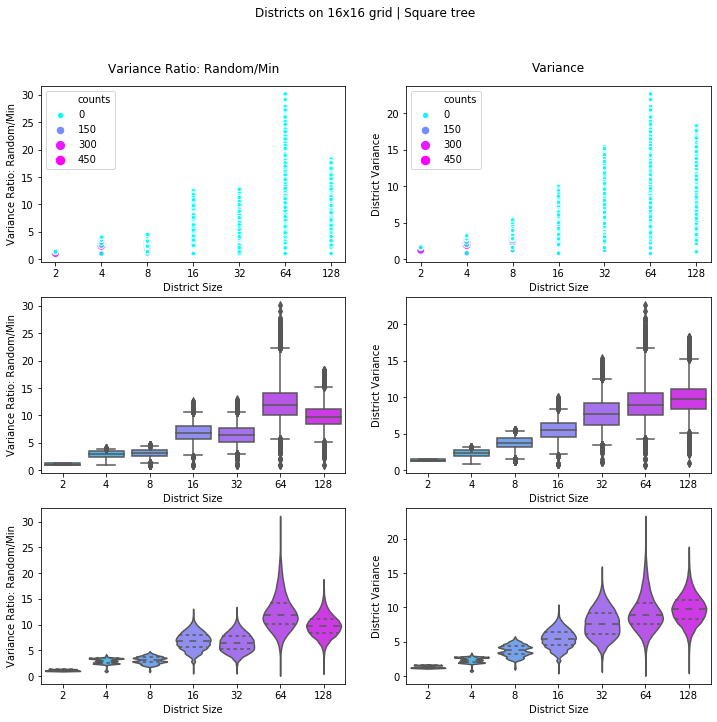

In [192]:
fig, axs = draw_results_grid(data1616grid, sizes_16, vars_16, ratios_16,
                  "Districts on 16x16 grid | Square tree", treetype="sq", figsize=(12, 11))
plt.savefig("plots/16_16_grid_square_tree.png", dpi=200)

In [193]:
print(data1616grid.query("size == '4'")["var"].min())  # init min
print(data1616grid.query("size == '16'")["var"].min()) # init min
print(data1616grid.query("size == '64'")["var"].min()) # init min

print(data1616grid.query("size == '2'")["var"].min())  # init min
print(data1616grid.query("size == '8'")["var"].min())
print(data1616grid.query("size == '32'")["var"].min())
print(data1616grid.query("size == '128'")["var"].min()) # init min

0.7998046875
0.796875
0.75
1.199951171875
1.19921875
1.1875
1.0


In [183]:
p = init_part_128
i = list(p.parts.keys())[0]

In [184]:
d = {p.graph.nodes[n]["geoid_sq"]: int(n in p.parts[i]) for n in p.graph.nodes}

In [185]:
h_16_sq.assign_district_tree_varriance(d)

1.0

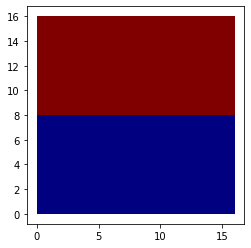

In [186]:
p.plot(cmap="jet")